## Fitting Cumulative Correct Rate in Curve


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
from datetime import datetime

In [33]:
def process_data(df):
    # omit unnecessary columns and rename
    df = df[['MM:DD:YYYY hh:mm:ss', 'Event', 'Active_Poke']].rename(
    columns={'MM:DD:YYYY hh:mm:ss': 'Time_Stamp'})
    df = df.replace({'LeftWithPellet': 'Left', 'LeftDuringDispense': 'Left',
                                   'RightWithPellet': 'Right', 'RightDuringDispense': 'Right'})
    df['Time_Stamp'] = pd.to_datetime(df['Time_Stamp'])

    # Group data by every 4 hours and calculate correct rate
    result = df.groupby(pd.Grouper(key='Time_Stamp', freq='30T')).apply(lambda group: (
    group['Event'] == group['Active_Poke']).sum() / group['Event'].isin(['Left', 'Right']).sum()).reset_index()
    result.columns = ['Time_Stamp', 'Correct_Rate']
    result.dropna(inplace=True, axis='index')
    result['Time_Stamp'] = result['Time_Stamp'].apply(lambda x: x.timestamp())

    index = 0
    # drop columns starts with 1 - very badly influence on trend
    # find first non-1 start point
    for idx, row in result.iterrows():
        if row['Correct_Rate'] != 1:
            index = idx
            break
    result = result[index:]
    return result['Time_Stamp'], result['Correct_Rate']

/var/folders/kk/3lqkkjzx7kb59yj16vgzwnyh0000gn/T/ipykernel_16633/1175299261.py:10: RuntimeWarning: invalid value encountered in long_scalars
  result = df.groupby(pd.Grouper(key='Time_Stamp', freq='30T')).apply(lambda group: (


<Axes: xlabel='Time_Stamp', ylabel='Correct_Rate'>

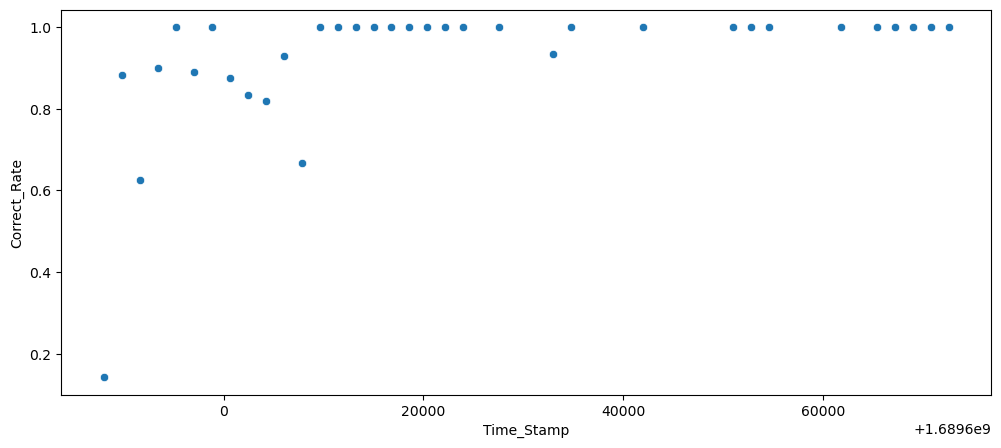

In [34]:
df = pd.read_csv('../behavior data integrated/Bhv 8 - Cask/M1/FR1/FED000_071723_01.CSV')
X,y = process_data(df)

plt.figure(figsize=(12, 5))
sns.scatterplot(x=X, y=y)


In [4]:
def sigmoid(x, L, x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

In [24]:
def graph_sigmoid(X, y):
    p0 = [max(y), X.median(), min(X), min(y)]

    popt, pcov = curve_fit(sigmoid, X, y, p0, method='dogbox')

    L, x0, k, b = popt

    print("Optimal Parameters:")
    print(f"L = {L}")
    print(f"x0 = {x0}")
    print(f"k = {k}")
    print(f"b = {b}")
    print(datetime.fromtimestamp(x0*3600))
    y_pred = sigmoid(X, L, x0, k, b)
    sns.scatterplot(x=X, y=y)
    sns.lineplot(x=X, y=y_pred, color='red')
    plt.show()

Optimal Parameters:
L = 0.12916666666666687
x0 = 469337.6657209309
k = 469330.3333333333
b = 0.8678030303030297
2023-07-17 10:39:56.595351


/Users/yaomingyang/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


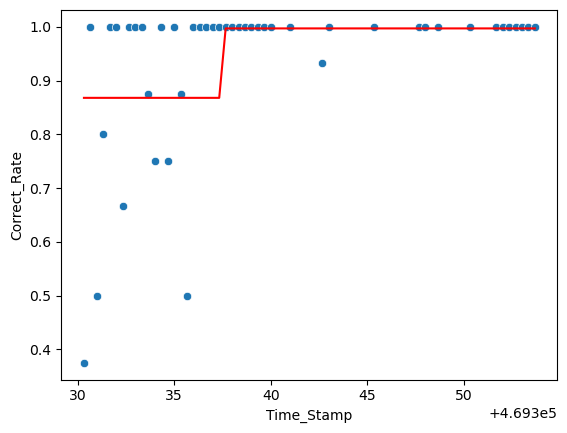

In [25]:
graph_sigmoid(X, y)